<a href="https://colab.research.google.com/github/bishair/Model-Improvements/blob/main/G10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import joblib
from IPython.display import display, clear_output

In [3]:
uploaded_file = files.upload()

Saving riverL.xlsx to riverL.xlsx


In [4]:
# Read the groundwater level data
gw_data = pd.read_excel('groundwater.xlsx')
gw_data.dropna(inplace=True)
gw_data['Date'] = pd.to_datetime(gw_data['Date'], format='%d/%m/%Y %H:%M')
#print(gw_data)

# Read the river water level data
river_data = pd.read_excel('riverL.xlsx')
river_data['Date'] = pd.to_datetime(river_data['Date'], format='%d/%m/%Y %H:%M')
#print(river_data)

# Merge the two datasets on the 'Date' column
merged_data = pd.merge_asof(gw_data.sort_values('Date'), river_data.sort_values('Date'), on='Date', direction='nearest')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)
print(merged_data)

                         G10  River
Date                               
2015-01-30 12:18:00  110.722    261
2015-01-30 13:18:00  110.720    260
2015-01-30 14:18:00  110.718    260
2015-01-30 15:18:00  110.715    260
2015-01-30 16:18:00  110.714    260
...                      ...    ...
2017-01-30 10:19:00  109.456    136
2017-01-30 11:19:00  109.455    138
2017-01-30 12:19:00  109.456    141
2017-01-30 13:19:00  109.457    144
2017-01-30 14:19:00  109.459    146

[17329 rows x 2 columns]


In [5]:
n_steps = 24

# Create a copy of the DataFrame to have date as column
merged_data_copy = merged_data.copy()
merged_data_copy.reset_index(inplace=True)
dates = merged_data_copy['Date']


# Split the merged data 70% training 30% testing
train_size = int(len(merged_data) * 0.7)
merged_data_train = merged_data[:train_size]
merged_data_test = merged_data[train_size:]


# Split dates along with the data
dates_train = dates[:train_size]
dates_test = dates[train_size:]

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(merged_data_train)
test_scaled = scaler.transform(merged_data_test)

#Save the scaler
joblib.dump(scaler, 'scaler.gz')

def create_sequences_with_dates(data, dates, n_steps):
    X, y, dates_seq = [], [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 0])
        dates_seq.append(dates.iloc[i - n_steps + 1 : i + 1])  # Capture the full range of dates for each sequence
    return np.array(X), np.array(y), np.array(dates_seq)

# create sequences
X_train, y_train, dates_train_seq = create_sequences_with_dates(train_scaled, dates_train, n_steps)
X_test, y_test, dates_test_seq = create_sequences_with_dates(test_scaled, dates_test, n_steps)

#Numpy arrays
#print('X_train shape:', X_train.shape)
#print('y_train shape:', y_train.shape)
#print('X_test shape:', X_test.shape)
#print('y_test shape:', y_test.shape)
#print('Dates for training data',dates_train_seq)
#print('Dates for testing data',dates_test_seq.shape)

In [6]:
from sklearn.model_selection import train_test_split

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Epoch 1/25
606/606 [==============================] - ETA: 0s - loss: 0.0584
Epoch 1: val_loss improved from inf to 0.00458, saving model to best_model.h5
606/606 [==============================] - 43s 62ms/step - loss: 0.0584 - val_loss: 0.0046
Epoch 2/25
  1/606 [..............................] - ETA: 51s - loss: 0.0053

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


605/606 [============================>.] - ETA: 0s - loss: 0.0059
Epoch 2: val_loss improved from 0.00458 to 0.00229, saving model to best_model.h5
606/606 [==============================] - 35s 58ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 3/25
606/606 [==============================] - ETA: 0s - loss: 0.0052
Epoch 3: val_loss did not improve from 0.00229
606/606 [==============================] - 36s 60ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 4/25
605/606 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 4: val_loss did not improve from 0.00229
606/606 [==============================] - 35s 58ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 5/25
605/606 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 5: val_loss improved from 0.00229 to 0.00162, saving model to best_model.h5
606/606 [==============================] - 36s 59ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 6/25
606/606 [==============================] - ETA: 0s - loss: 0.0040
Epoc

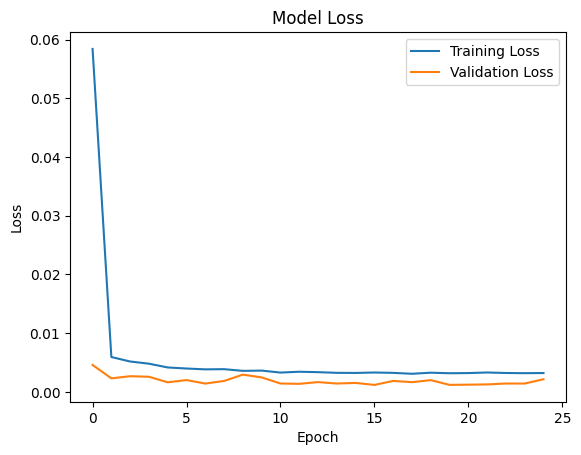

In [7]:
input_shape=(X_train.shape[1], X_train.shape[2])

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l1_l2

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=input_shape,   #input shape => (timesteps, features).  X => (samples, timesteps, features)
         dropout=0.2, recurrent_dropout=0.2,
         kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.2),
    LSTM(units=50, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Fit the model with validation data and callbacks
history = model.fit(
    X_train, y_train, epochs=25, batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
model.save('lstmmodel.h5')
model = load_model('lstmmodel.h5')
scaler = joblib.load('scaler.gz')

In [9]:
# Only use 360 hours (15days) from X and y to test the real time part. Use evaluate on X-test-evaluate and real time workflow on X-realtime
# Calculate the index for splitting the test data to exclude the last 360 points
split_index = len(X_test) - 360

# Split X_test into two parts
# X_test_eval will have all the data points from the start up to the split_index
X_test_eval = X_test[:split_index]

# X_test_realtime will have the last 360 data points
X_test_realtime = X_test[split_index:]

# Apply the same split to y_test and dates_test_seq
y_test_eval = y_test[:split_index]
y_test_realtime = y_test[split_index:]

dates_test_eval_seq = dates_test_seq[:split_index]
dates_test_realtime_seq = dates_test_seq[split_index:]

# X_test_eval, y_test_eval, and dates_test_eval_seq are for model evaluation (excluding the last 360 points)
# X_test_realtime, y_test_realtime, and dates_test_realtime_seq are for real-time testing (only the last 360 points)
print('X_test_eval shape',X_test_eval.shape)
print('y_test_eval shape',y_test_eval.shape)
print('dates_test_realtime_seq',dates_test_realtime_seq)

X_test_eval shape (4815, 24, 2)
y_test_eval shape (4815,)
dates_test_realtime_seq [['2017-01-14T16:19:00.000000000' '2017-01-14T17:19:00.000000000'
  '2017-01-14T18:19:00.000000000' ... '2017-01-15T13:19:00.000000000'
  '2017-01-15T14:19:00.000000000' '2017-01-15T15:19:00.000000000']
 ['2017-01-14T17:19:00.000000000' '2017-01-14T18:19:00.000000000'
  '2017-01-14T19:19:00.000000000' ... '2017-01-15T14:19:00.000000000'
  '2017-01-15T15:19:00.000000000' '2017-01-15T16:19:00.000000000']
 ['2017-01-14T18:19:00.000000000' '2017-01-14T19:19:00.000000000'
  '2017-01-14T20:19:00.000000000' ... '2017-01-15T15:19:00.000000000'
  '2017-01-15T16:19:00.000000000' '2017-01-15T17:19:00.000000000']
 ...
 ['2017-01-29T13:19:00.000000000' '2017-01-29T14:19:00.000000000'
  '2017-01-29T15:19:00.000000000' ... '2017-01-30T10:19:00.000000000'
  '2017-01-30T11:19:00.000000000' '2017-01-30T12:19:00.000000000']
 ['2017-01-29T14:19:00.000000000' '2017-01-29T15:19:00.000000000'
  '2017-01-29T16:19:00.000000000' .

151/151 [==============================] - 1s 9ms/step
Mean Squared Error: 0.001114373754840268


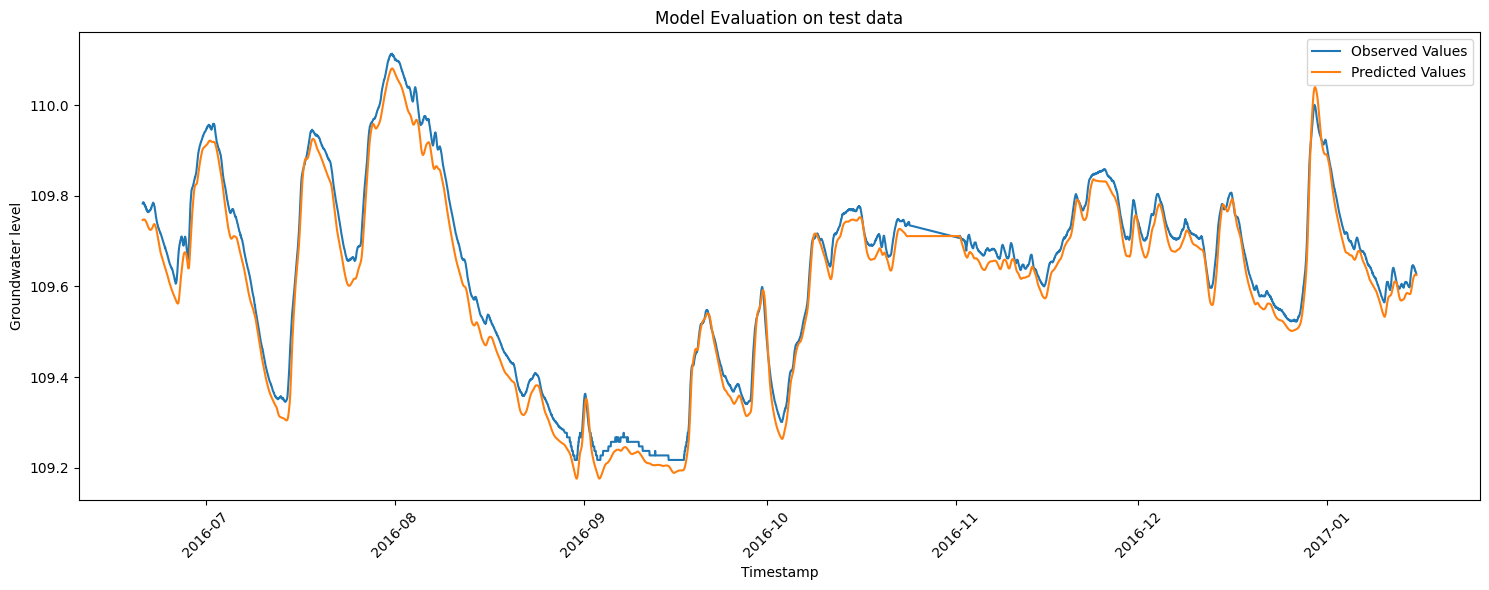

In [22]:
y_pred = model.predict(X_test_eval)
y_pred = y_pred.reshape(-1, 1)
# Create a dummy array with the same number of samples and one less feature
dummy_feature = np.zeros((y_pred.shape[0], 1))
# Concatenate the predictions with this dummy array
concat_pred = np.concatenate([y_pred, dummy_feature], axis=1)
# Inverse transform and then take only the first column  (actual predictions)
y_pred_inverse = scaler.inverse_transform(concat_pred)[:, 0]
# Evaluate the trained model on X_test_eval, y_test_eval, and dates_test_eval_seq and plot the predictions with the corresponding dates

# Extracting the last timestamp from each sequence for plotting
x_eval_timestamps = [dates[-1] for dates in dates_test_eval_seq]

# Reshape y_test_eval for concatenation
y_test_eval_reshaped = y_test_eval.reshape(-1, 1)
# Create a dummy feature with the same number of samples
dummy_feature_eval = np.zeros_like(y_test_eval_reshaped)
# Concatenate y_test_eval with the dummy feature
concat_eval = np.concatenate([y_test_eval_reshaped, dummy_feature_eval], axis=1)
# Inverse transform and extract the relevant part
y_test_eval_inverse = scaler.inverse_transform(concat_eval)[:, 0]

# Calculate MSE
mse = mean_squared_error(y_test_eval_inverse, y_pred_inverse)
print(f"Mean Squared Error: {mse}")

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(x_eval_timestamps, y_test_eval_inverse, label='Observed Values')
plt.plot(x_eval_timestamps, y_pred_inverse, label='Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Groundwater level')
plt.title('Model Evaluation on test data')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




1.   Introduce anomalies in X_anomalous(for river level only). Copy the X_anomalous containing anomalies in X_anomalous_without_retraining and X_anomalous_retraining
2.   Make a dynamic graph. Claculate MSE for X_anomalous_without_retraining for anomalies only
3.   Make a dynamic graph. Claculate MSE for X_anomalous_with_retraining for anomalies only
4. Compare above 2 graphs and see differences in graphs and MSE




In [33]:
#Create a copy of X-test-realtime and introduce anomalies in it
print(X_test_realtime.shape)
print(X_test_realtime)
print('dates_test_realtime_seq',len(dates_test_realtime_seq))
print(dates_test_realtime_seq)

(360, 24, 2)
[[[0.30238332 0.31439394]
  [0.30536246 0.33333333]
  [0.30784508 0.33333333]
  ...
  [0.30933466 0.28030303]
  [0.30834161 0.27272727]
  [0.30784508 0.27272727]]

 [[0.30536246 0.33333333]
  [0.30784508 0.33333333]
  [0.31032771 0.33333333]
  ...
  [0.30834161 0.27272727]
  [0.30784508 0.27272727]
  [0.30784508 0.27272727]]

 [[0.30784508 0.33333333]
  [0.31032771 0.33333333]
  [0.31181728 0.32954545]
  ...
  [0.30784508 0.27272727]
  [0.30784508 0.27272727]
  [0.30734856 0.27272727]]

 ...

 [[0.2428004  0.21212121]
  [0.2428004  0.20833333]
  [0.24230387 0.20454545]
  ...
  [0.22293942 0.18939394]
  [0.2224429  0.19318182]
  [0.22194638 0.20075758]]

 [[0.2428004  0.20833333]
  [0.24230387 0.20454545]
  [0.24180735 0.1969697 ]
  ...
  [0.2224429  0.19318182]
  [0.22194638 0.20075758]
  [0.2224429  0.21212121]]

 [[0.24230387 0.20454545]
  [0.24180735 0.1969697 ]
  [0.2408143  0.19318182]
  ...
  [0.22194638 0.20075758]
  [0.2224429  0.21212121]
  [0.22293942 0.22348485]

In [51]:
# Reshape the data for inverse transformation
X_test_realtime_reshaped = X_test_realtime.reshape(-1, 2)

# Inverse transform using the saved scaler
X_test_realtime_inverse = scaler.inverse_transform(X_test_realtime_reshaped)

# Reshape back to original shape
X_test_realtime_inverse = X_test_realtime_inverse.reshape(X_test_realtime.shape)


In [35]:
import pandas as pd

# Extract last date from each sequence
dates = [dates_seq[-1] for dates_seq in dates_test_realtime_seq]

# Extract corresponding G10 and River values (last values in each sequence)
G10_values = X_test_realtime_inverse[:, -1, 0]  # Last G10 value of each sequence
River_values = X_test_realtime_inverse[:, -1, 1]  # Last River value of each sequence

# Prepare DataFrame for export
data_for_export = pd.DataFrame({
    'Date': dates,
    'G10': G10_values,
    'River': River_values
})


In [36]:
# Export to Excel
data_for_export.to_excel("data_export.xlsx", index=False)


In [37]:
from google.colab import files

files.download('data_export.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
'''uploaded_file = files.upload()'''

Saving noanomalies.xlsx to noanomalies.xlsx


In [47]:
'''real_time_data = pd.read_excel('noanomalies.xlsx')'''

In [49]:
'''# Assuming real_time_data is a DataFrame containing your real-time data
real_time_data = pd.DataFrame({
    'Date': pd.date_range(start='2017-01-15 15:19:00', periods=360, freq='H'),
    'G10': np.random.uniform(109.4, 109.6, 360),  # Replace with your G10 values
    'River': np.random.randint(135, 160, 360)  # Replace with your River values
})

# Drop the 'Date' column and scale the data
real_time_data_scaled = scaler.transform(real_time_data.drop('Date', axis=1))

# Create sequences from the real-time data
X_realtime, _, dates_realtime_seq = create_sequences_with_dates(real_time_data_scaled, real_time_data['Date'], n_steps)

# Now X_realtime and dates_realtime_seq are prepared for prediction
print(X_realtime.shape)
print(len(dates_realtime_seq))'''

(336, 24, 2)
336


1/1 [==============================] - 0s 40ms/step


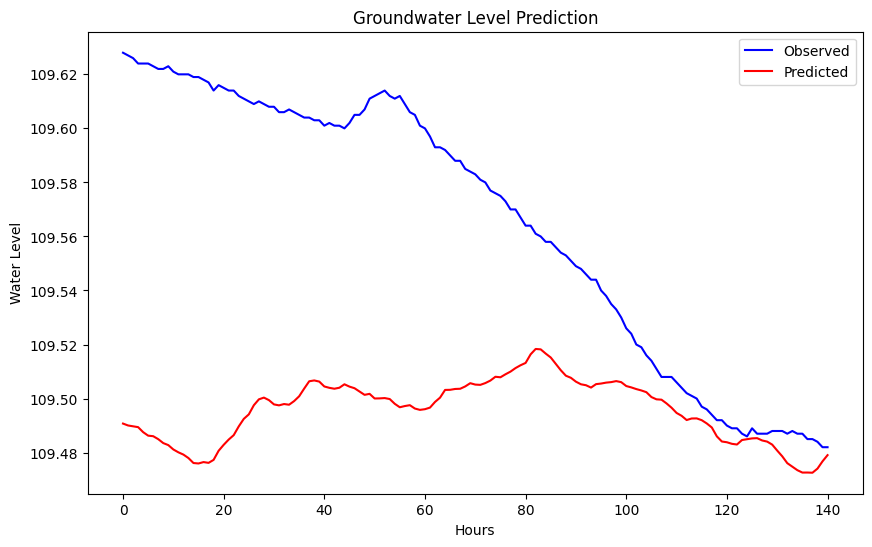

KeyboardInterrupt: 

In [50]:
'''import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import numpy as np

# Prediction and plotting code
window_size = 24
actual_values = []
predicted_values = []
errors = []

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(X_realtime.shape[0]):
    X_input = X_realtime[i, :, :]
    X_input = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))

    # Make a prediction
    forecast = model.predict(X_input)
    dummy = np.zeros((1, 2))
    dummy[:, 0] = forecast[:, 0]
    forecasted_value = scaler.inverse_transform(dummy)[0, 0]
    predicted_values.append(forecasted_value)

    actual = y_test_realtime[i] if i < len(y_test_realtime) else None
    if actual is not None:
        actual_transformed = scaler.inverse_transform([[actual, 0]])[0, 0]
        actual_values.append(actual_transformed)

    error = abs(forecasted_value - actual_transformed) if actual is not None else 0
    errors.append(error)

    ax.clear()
    ax.plot(actual_values, label='Observed', color='blue')
    ax.plot(predicted_values, label='Predicted', color='red')
    ax.set_title('Groundwater Level Prediction')
    ax.set_xlabel('Hours')
    ax.set_ylabel('Water Level')
    ax.legend()

    # Error analysis and anomaly detection (your custom logic here)
    # ...

    display(fig)
    plt.pause(0.5)
    clear_output(wait=True)

plt.close(fig)'''


In [21]:
'''import numpy as np

# Assuming X is your scaled data array and is of shape [samples, timesteps, features]
river_data_scaled = X[:, :, 1]  # Extracting only the river water level data

# Flatten the river data to a 2D array (combining samples and timesteps)
river_data_2d = river_data_scaled.reshape(-1, 1)

# Reverse scaling for river data
# We concatenate with a dummy column to match the scaler's expected input shape
river_data_original = scaler.inverse_transform(np.hstack((np.zeros_like(river_data_2d), river_data_2d)))[:, 1]

# Anomaly thresholds
max_val, min_val = 481, 85
upper_extreme = max_val * 1.1  # 10% increase
lower_extreme = min_val * 0.9  # 90% of original value

# Randomly select 30% of the data points for anomaly introduction
anomaly_indices = np.random.choice(len(river_data_original), int(len(river_data_original) * 0.3), replace=False)

# Apply anomalies
for idx in anomaly_indices:
    if river_data_original[idx] >= max_val:
        river_data_original[idx] = upper_extreme
    elif river_data_original[idx] <= min_val:
        river_data_original[idx] = lower_extreme

# Rescale the river data
river_data_scaled_anomalies = scaler.transform(np.hstack((np.zeros_like(river_data_2d), river_data_original.reshape(-1, 1))))[:, 1]


# Reshape back to the original 3D structure and integrate into X
X_anomalies = X.copy()
X_anomalies[:, :, 1] = river_data_scaled_anomalies.reshape(X.shape[0], X.shape[1])
print(river_data_original)'''

[168. 173. 173. ... 138. 141. 144.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
'''#Function to introduce anomalies in copy of X-test data. Compare model performance then on copy Xtest with anomalies and Xtest without anomalies
#X-tets is scales? Anomalies scaling?
def introduce_anomalies(X_test, anomaly_type="shift", magnitude=5.0, frequency=0.01):
    """
    Introduce anomalies into the test dataset.

    Parameters:
    X_test (numpy array): The test dataset.
    anomaly_type (str): Type of anomaly - 'spike', 'shift', 'noise', or 'gap'.
    magnitude (float): Magnitude of the anomaly.
    frequency (float): Frequency of anomalies (as a fraction of the total length of X_test).
    """
    # Copy the dataset to avoid modifying the original
    X_anomalous = np.copy(X_test)

    num_samples = X_anomalous.shape[0]
    num_anomalies = int(num_samples * frequency)

    # Indices where anomalies will be introduced
    anomaly_indices = np.random.choice(num_samples, num_anomalies, replace=False)

    if anomaly_type == "spike":
        # Introduce spikes
        for idx in anomaly_indices:
            X_anomalous[idx] *= magnitude

    elif anomaly_type == "shift":
        # Introduce shifts in mean
        shift_value = np.random.rand() * magnitude
        for idx in anomaly_indices:
            X_anomalous[idx] += shift_value

    elif anomaly_type == "noise":
        # Introduce random noise
        noise = np.random.normal(0, magnitude, X_anomalous.shape[1])
        for idx in anomaly_indices:
            X_anomalous[idx] += noise

    return X_anomalous

# Example usage
X_test_anomalous = introduce_anomalies(X_test_realtime, anomaly_type="spike", magnitude=10, frequency=0.05)'''

In [ ]:
# Function to retrain the model with new data
def retrain_model(model, X_new, y_new, epochs=5, batch_size=32):
    # Partial retraining of the model with new data
    model.fit(X_new, y_new, epochs=epochs, batch_size=batch_size, shuffle=True)
    return model